In [0]:
import warnings
warnings.filterwarnings("ignore")

In [55]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
cp -f /gdrive/My\ Drive/fashion-mnist_train.csv .

In [0]:
!cp -f /gdrive/My\ Drive/alpha.py .
!cp -f /gdrive/My\ Drive/cnn_utils.py .

In [0]:

from alpha import iterate_minibatches
from alpha import saveGraph
from alpha import lrelu
from alpha import make_square
from cnn_utils import  conv_layer, fc_layer

In [0]:
import tensorflow as tf
import os, cv2, random
import numpy as np
import pandas as pd
import time, math
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from collections import OrderedDict

%matplotlib inline

In [60]:
tf.__version__

'1.14.0-rc1'

In [61]:
!ls

alpha.py      Embeddings	       pb	    sample_data  summary_log
cnn_utils.py  fashion-mnist_train.csv  __pycache__  saved_model


In [0]:
# cp -f ./fashion-mnist_train.csv /gdrive/My\ Drive/

In [0]:
'''
Designing auto encoder network.
'''
graph = tf.Graph()

In [0]:
with graph.as_default():
    '''
    two placeholder to place input and output images. 
    Technically this will be same image.
    '''
    X = tf.placeholder(tf.float32,[None,28,28,1])
    Y = tf.placeholder(tf.float32,[None,28,28,1])

In [0]:
'''
Encoder network:
    This will map the input image to a euclidian space
    Name scope has added to view the network clearly on tensorboard
'''
with graph.as_default():
    with tf.name_scope('en-convolutions'):
        conv0 = tf.layers.conv2d(X,filters=4,kernel_size=(3,3),strides=(1,1),padding='SAME',use_bias=True,activation=lrelu,name='conv0')
    with tf.name_scope('en-pooling'):
        maxpool0 = tf.layers.max_pooling2d(conv0,pool_size=(2,2),strides=(2,2),name='pool0')     
    
    with tf.name_scope('en-convolutions'):
        conv1 = tf.layers.conv2d(maxpool0,filters=4,kernel_size=(3,3),strides=(1,1),padding='SAME',use_bias=True,activation=lrelu,name='conv1')
    with tf.name_scope('en-pooling'):
        maxpool1 = tf.layers.max_pooling2d(conv1,pool_size=(2,2),strides=(2,2),name='pool1')
    
    with tf.name_scope('en-convolutions'):
        conv2 = tf.layers.conv2d(maxpool1,filters=8,kernel_size=(3,3),strides=(1,1),padding='SAME',use_bias=True,activation=lrelu,name='conv2')
    with tf.name_scope('en-pooling'):
        maxpool2 = tf.layers.max_pooling2d(conv2,pool_size=(2,2),strides=(2,2),name='pool2')
    
    with tf.name_scope('en-convolutions'):
        conv3 = tf.layers.conv2d(maxpool2,filters=16,kernel_size=(3,3),strides=(1,1),padding='SAME',use_bias=True,activation=lrelu,name='conv3')
    with tf.name_scope('encoding'):
        encoded = tf.layers.average_pooling2d(conv3,pool_size=(2,2),strides=(2,2),name='encoding')

In [66]:
'''
The last tensor, 'encoded',  will be a of shape (?, 1, 1, 16), which then will be flattened to shape (, 256).
This will be the compressed representation of the input image
'''
encoded

<tf.Tensor 'encoding/encoding/AvgPool:0' shape=(?, 1, 1, 16) dtype=float32>

In [0]:
'''
Decoder network:
This will map the encodings back to image of same input shape
'''
with graph.as_default():
    with tf.name_scope('decoder'):
        upsample1 = tf.layers.conv2d_transpose(encoded,filters=16,kernel_size=3,padding='valid',strides=2,name='upsample1')
        conv4 = tf.layers.conv2d(upsample1,filters=16,kernel_size=(3,3),strides=(1,1),padding='SAME',name='conv4',use_bias=True,activation=lrelu)#upsample1 #
        
        upsample2 = tf.layers.conv2d_transpose(conv4,filters=8,kernel_size=3,padding='valid',strides=2,name='upsample2') 
        conv5 = tf.layers.conv2d(upsample2,filters=8,kernel_size=(3,3),strides=(1,1),name='conv5',padding='SAME',use_bias=True,activation=lrelu)#upsample2 #
        
        upsample3 = tf.layers.conv2d_transpose(conv5,filters=8,kernel_size=5,padding='same',strides=2,name='upsample3')
        conv6 = tf.layers.conv2d(upsample3,filters=4,kernel_size=(5,5),strides=(1,1),name='conv6',padding='SAME',use_bias=True,activation=lrelu)
        
        upsample4 = tf.layers.conv2d_transpose(conv6,filters=8,kernel_size=5,padding='same',strides=2,name='upsample4')
        conv7 = tf.layers.conv2d(upsample4,filters=4,kernel_size=(5,5),strides=(1,1),name='conv7',padding='SAME',use_bias=True,activation=lrelu)
        
        logits = tf.layers.conv2d(conv7,filters=1,kernel_size=(3,3),strides=(1,1),name='logits',padding='SAME',use_bias=True)
        decoded = tf.sigmoid(logits,name='recon')

In [68]:
logits

<tf.Tensor 'decoder/logits/BiasAdd:0' shape=(?, 28, 28, 1) dtype=float32>

In [0]:
# for op in graph.get_operations():
#      print(op.name)

In [0]:
dir = './train/fashionmnist/'

In [71]:
train = pd.read_csv('./fashion-mnist_train.csv')
train = train.drop(columns='label')
train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,227,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,136,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,0,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [72]:
train.shape

(60000, 784)

In [0]:
train_ar = np.array(train)
train_ar = train_ar.reshape(-1, 28, 28,1)

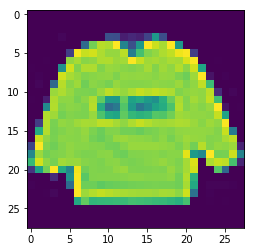

In [74]:
plt.imshow(train_ar[0].reshape(28,28))
plt.show()

In [75]:
train_ar[0].shape

(28, 28, 1)

In [0]:
with graph.as_default():
    '''
    Defining loss function and optimizer
    '''
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits)
    lr = tf.placeholder(tf.float32, shape=[])
    cost = tf.reduce_mean(loss, name ='cost')
    opt = tf.train.AdamOptimizer(learning_rate=lr, name='opt').minimize(cost) #optimizer
    
    summaryMerged = tf.summary.merge_all() #For tensorboard
    filename="./summary_log/run-"+time.strftime("%d%m-%H%M%S")

In [77]:
'''
Ran 10 epochs with learning rate decay and different mini batch sizes.
Every 10 epochs,
training had stopped and checked the model performance by ploting 'predicted duplicates' 
of random products and validated
'''

minibatch_size = 256
epoch = 10
learning_rate = 0.00002

with tf.Session(graph=graph) as sess:
    writer = tf.summary.FileWriter(filename, sess.graph) 
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
#     saver.restore(sess, tf.train.latest_checkpoint('./saved_model/'))
    for ep in range(epoch):
      avg_cost = 0
      batch_costs=[]
      for i, minibatch in enumerate(iterate_minibatches(train_ar, minibatch_size)):
        batch_cost, _ = sess.run([cost, opt], feed_dict={X: minibatch/255,
                                                             Y: minibatch/255,
                                                            lr: learning_rate})
        batch_costs.append(batch_cost)
      print(i)
      print("Epoch: {}/{}...".format(ep+1, epoch), \
                  "Training loss: {:.4f}".format(batch_cost/i))
    saver.save(sess, "./saved_model/model")

234
Epoch: 1/10... Training loss: 0.0029
234
Epoch: 2/10... Training loss: 0.0028
234
Epoch: 3/10... Training loss: 0.0026
234
Epoch: 4/10... Training loss: 0.0024
234
Epoch: 5/10... Training loss: 0.0023
234
Epoch: 6/10... Training loss: 0.0021
234
Epoch: 7/10... Training loss: 0.0020
234
Epoch: 8/10... Training loss: 0.0019
234
Epoch: 9/10... Training loss: 0.0019
234
Epoch: 10/10... Training loss: 0.0018


In [78]:
train1 = pd.read_csv('./fashion-mnist_train.csv')
train1 = np.array(train1)
train1[:,:1]

array([[2],
       [9],
       [6],
       ...,
       [8],
       [8],
       [7]])

In [79]:
'''
Read all images; 
Calculate embeddings for each images
Append the embeddings and product index to two seperate arrays
'''
limit = 99999
IMG_SIZE = 64
embeddings = []
labels = []
with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('./saved_model/'))
    for i, im in (enumerate(range(len(train_ar)))):
      img = train_ar[im].reshape(1,28,28,1)
 
          
      img = img/255.0
    
      embeddings.append(sess.run(encoded,feed_dict={X:img}).reshape(-1,16))
      if i%10000 ==0:
        print(i)
#       labels.append(int(path.split('.')[-2].split('-')[-1]))  
#             print(int(path.split('.')[-2].split('-')[-1]))
# labels = np.array(labels)
embeddings = np.array(np.squeeze(embeddings))

0
10000
20000
30000
40000
50000


In [0]:
# for op in graph2.get_operations():
#      print(op.name)

In [0]:
'''
Writing the weights to pb file for prediction/serving
'''
graph2 = tf.Graph()
with tf.Session(graph=graph2) as sess:
    saver = tf.train.import_meta_graph('./saved_model/model.meta')
    input_graph_def = tf.get_default_graph().as_graph_def()
    saver.restore(sess, "./saved_model/model")
    
    output_node_names="encoding/encoding/AvgPool"
    output_graph_def = tf.graph_util.convert_variables_to_constants(sess,
                                                      input_graph_def,
                                                      output_node_names.split(","))
    output_graph="./pb/TunicsEncoder-v0.1.pb"
    with tf.gfile.GFile(output_graph, "wb") as f:
        f.write(output_graph_def.SerializeToString())

In [82]:
!mkdir pb

mkdir: cannot create directory ‘pb’: File exists


In [83]:
!mkdir Embeddings

mkdir: cannot create directory ‘Embeddings’: File exists


In [84]:
960000/256


3750.0

In [0]:
'''
Dumping and saving  to .npy format.
Used for development purpose; had to restart notebokk several time, this method of reading is always faster.
'''
np.save('./Embeddings/embeddings.npy', embeddings)
np.save('./Embeddings/labels.npy', labels)
embeddings = np.load('./Embeddings/embeddings.npy').reshape(60000,16)  #since 37547 items
# labels = np.load('./Embeddings/labels.npy').reshape(3750,)

In [0]:
'''
Creating Dataframe with each embeddings elements as columns(total 256 columns) and coresponding labels as the index
'''
data = pd.DataFrame(embeddings)
# data['labels'] = labels
# data.set_index('labels', inplace=True)
data.sort_index(inplace=True)

In [87]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.763202,-0.268274,-0.191803,-0.142485,1.925211,1.174257,-0.250867,3.197595,1.426911,1.162868,2.869175,-0.314382,-0.340798,0.534299,1.446474,0.223852
1,0.978905,-0.165053,-0.166581,-0.096085,1.660206,1.610750,-0.124042,1.712572,1.655567,0.862424,1.627561,-0.186789,-0.211613,0.172309,0.723912,0.433578
2,0.340120,-0.271294,-0.180463,-0.167365,2.042164,0.890669,-0.220301,3.100001,1.175439,1.338968,2.893892,-0.310848,-0.341146,0.428659,1.333570,0.163761
3,0.230451,-0.239975,-0.148446,-0.158216,1.752582,0.639761,-0.186109,2.692811,1.001415,1.294887,2.567509,-0.281718,-0.308686,0.285665,1.077032,0.047609
4,0.222948,-0.255069,-0.162406,-0.174891,1.985341,0.792004,-0.195603,2.865238,1.161863,1.621006,2.783281,-0.302337,-0.334673,0.285998,1.122028,0.077872


In [0]:
def getEmbeddings(idx):
  
  '''
  Calculates embedding vector given a single image
  input: index of single image to be tested
  return: Embeddings of shape (256,)
  '''
  IMG_SIZE = 64
  
 
  img = train_ar[idx].reshape(1,28,28,1)
  img = img/255.0
    
#     img = cv2.imread('./train/im-400-{}.jpg'.format(idx))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
#     img = img/255.0
    
  with tf.Session(graph=graph) as sess:
      saver = tf.train.Saver()
      saver.restore(sess, tf.train.latest_checkpoint('./saved_model/'))
      dist = sess.run(encoded,feed_dict={X:img.reshape((-1,28,28,1))})
  
  return np.squeeze(dist.reshape(-1,16))

In [0]:
#Reading images with index of 'scores' dataframe
def getPredictedImages(score):
    '''
    loading images with id equals to index of 'score'
    '''
    images = []
    IMG_SIZE = 200
    for idx in score.index:
      
      
      img = train_ar[idx].reshape(1,28,28,1)
      
      
#         path = './train/im-400-{}.jpg'.format(idx)
#         img = Image.open(path)
#         img  = make_square(img)
#         img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
      images.append([np.array(img)])
    return np.array(images).reshape(-1,28,28,1)

In [0]:
def getPredictions(testEmbeddings):
    '''
    input: Embeddings a single test image; shape- (256,)
    return: Dataframe contains details of top 10 similar images
    and 
    '''
    dist = (np.array(data) - testEmbeddings)**2
    dist = np.sum(dist, axis=1)
    dist = np.sqrt(dist)    
    '''
    dist : Euclidean distance between testEmbedding and embeddings of all the images. dtype: numpy array
    '''
    
    df = pd.DataFrame({'distance':dist})
    df.index = data.index
    df.sort_values('distance', ascending=True, inplace=True) 
    score = df[:10] #Taking highest 10 
    score['score'] = df.distance[:10].apply(lambda x: np.round(1-np.tanh(x)**10, 3)).values
    '''
    tanh is used to map distance to 0 to 1
    '''
    return score

In [0]:
def getTestimage(idx):
    '''
    This is for ploting the original image
    reads image from directory given index
    '''
    img = train_ar[idx].reshape(28,28)
    return img

In [0]:
def plotImages(idx, im, images, score):
    images = images.reshape(-1,28,28)
    fig, axes = plt.subplots(5,2, figsize = (15,25))
    fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    for i, ax in enumerate(axes.flat):
        if i==0:
            idX = getinfo(idx)
            ax.imshow(im, cmap = 'binary')
            xlabel = "Original image ".format(idX)
            ax.set_xlabel(xlabel, fontsize = 13)
        else:    
            ax.imshow(images[i-1], cmap = 'binary')
            print(i)
            idX = getinfo(score.index[i])
            xlabel = "score: {} \nid:{}".format(score.score.iloc[i-1], idX)
        
            ax.set_xlabel(xlabel, fontsize = 12)
        
        #Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

In [0]:

Data = pd.read_csv('./fashion-mnist_train.csv')
Data = Data.label


def getinfo(idx):
    idX = Data[Data.index==idx].values[0]
    return idX

In [94]:
getinfo(4534)

4

In [95]:
Data = pd.read_csv('./fashion-mnist_train.csv')
Data = Data.label
Data[Data.index==4534].values[0]

4

1
2
3
4
5
6
7
8
9


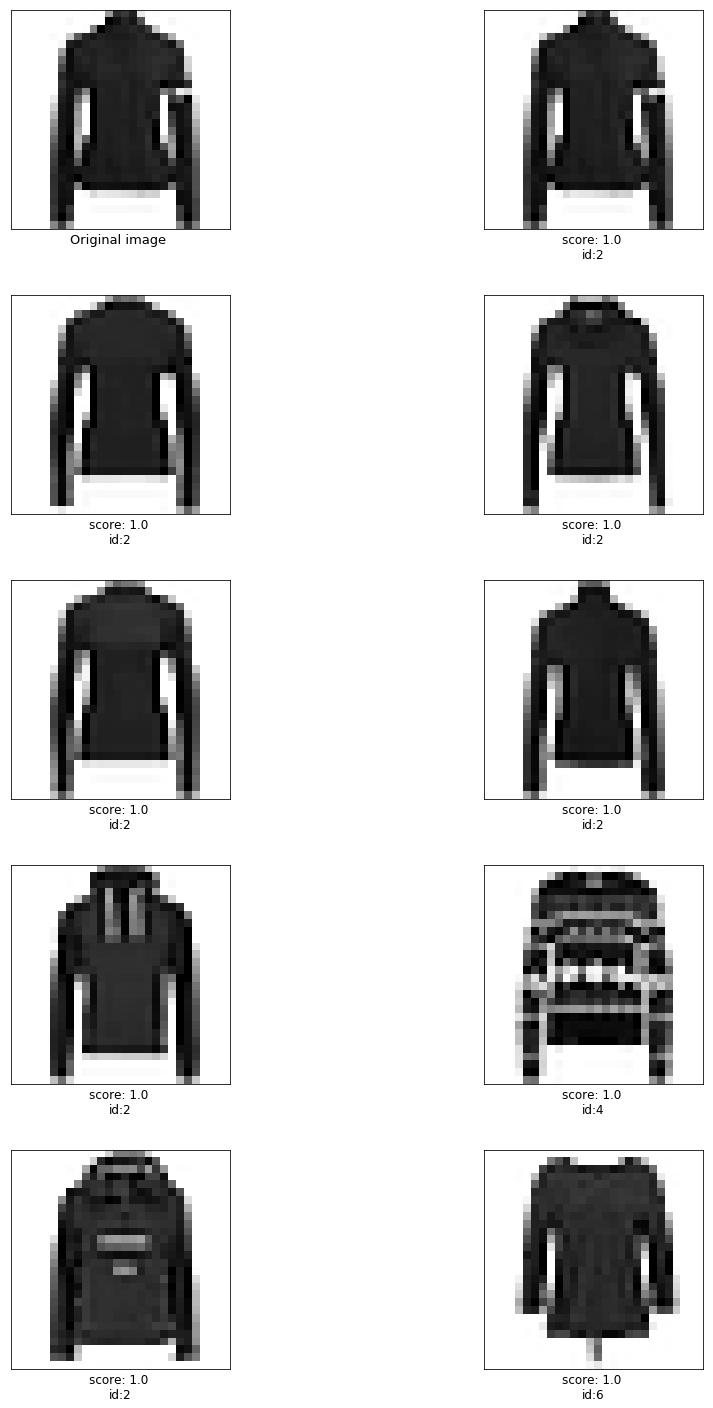

In [96]:
'''
Testing one image
'''
idx = 4534
testEmbeddings = getEmbeddings(idx)
score = getPredictions(testEmbeddings)
images =  getPredictedImages(score)
im = getTestimage(idx)
plotImages(idx, im, images, score)